In [1]:
!pip install torch

In [12]:
##using cool pipeline https://bytepawn.com/svm-with-pytorch.html

In [13]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1. Load Data
data = np.load('../data/dataset.npz', allow_pickle=True)
X_train_raw, Y_train_raw = data['arr_0'], data['arr_1']
X_test_raw, Y_test_raw   = data['arr_2'], data['arr_3']

num_classes = 46
train_per_class = 1600
val_per_class = 100

# 2. Manual Split Logic
X_train_new, Y_train_new = [], []
X_val, Y_val = [], []

for i in range(num_classes):
    start = i * 1700
    X_train_new.extend(X_train_raw[start : start + train_per_class])
    Y_train_new.extend(Y_train_raw[start : start + train_per_class])
    X_val.extend(X_train_raw[start + train_per_class : start + 1700])
    Y_val.extend(Y_train_raw[start + train_per_class : start + 1700])

# 3. Convert to Tensors & PCA (Exactly like sklearn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(data_list, labels):
    x = torch.from_numpy(np.stack([img.flatten() for img in data_list])).float() / 255.0
    y = torch.tensor(labels, dtype=torch.long) - 1
    return x, y

X_train_t, Y_train_t = preprocess(X_train_new, Y_train_new)
X_val_t, Y_val_t     = preprocess(X_val, Y_val)
X_test_t, Y_test_t   = preprocess(X_test_raw, Y_test_raw)

# Move to GPU for PCA
X_train_t = X_train_t.to(device)
mean = X_train_t.mean(dim=0)
U, S, V = torch.pca_lowrank(X_train_t - mean, q=200)

X_train_pca = torch.mm(X_train_t - mean, V)
X_val_pca   = torch.mm(X_val_t.to(device) - mean, V)
X_test_pca  = torch.mm(X_test_t.to(device) - mean, V)

print(f"PCA Setup Complete. Train shape: {X_train_pca.shape}")

PCA Setup Complete. Train shape: torch.Size([73600, 200])


In [14]:
class ExactGPURBF:
    def __init__(self, n_basis=8000, gamma=0.1):
        self.n_basis = n_basis
        self.gamma = gamma
        self.basis_points = None

    def fit(self, X):
        # Anchor points stay the same
        idx = torch.randperm(X.size(0))[:self.n_components] if hasattr(self, 'n_components') else torch.randperm(X.size(0))[:self.n_basis]
        self.basis_points = X[idx].clone()

    def transform(self, X, chunk_size=2000):
        """Processes X in chunks to avoid CUDA OutOfMemory errors."""
        n_samples = X.size(0)
        output = torch.zeros((n_samples, self.n_basis), device=device)
        
        for i in range(0, n_samples, chunk_size):
            end = min(i + chunk_size, n_samples)
            # Compute distance for only this block
            dist_sq = torch.cdist(X[i:end], self.basis_points).pow(2)
            output[i:end] = torch.exp(-self.gamma * dist_sq)
            
            # Clear cache to keep memory clean
            del dist_sq
            
        return output

# Initialize with lower basis if needed, but 8000 should work with chunking
rbf_machine = ExactGPURBF(n_basis=8000, gamma=0.1) 
rbf_machine.fit(X_train_pca)

print("Computing Exact Kernel Matrices in chunks...")
X_train_rbf = rbf_machine.transform(X_train_pca)
X_val_rbf   = rbf_machine.transform(X_val_pca)
X_test_rbf  = rbf_machine.transform(X_test_pca)

Computing Exact Kernel Matrices in chunks...


In [15]:
def solve_svm_exact(K, Y, C_val):
    n_features = K.shape[1]
    Y_onehot = torch.nn.functional.one_hot(Y, 46).float()
    
    # Regularization
    lambda_inv = 1.0 / C_val
    identity = torch.eye(n_features, device=device) * lambda_inv
    
    # Solve (K.T @ K + identity) @ W = K.T @ Y_onehot
    # K.T @ K is only 8000x8000, which is ~256MB. This is safe.
    A = torch.mm(K.t(), K) + identity
    B = torch.mm(K.t(), Y_onehot)
    
    w = torch.linalg.solve(A, B)
    return w

# Re-running the Search
C_list = [0.1 * i for i in range(1, 15)] # Shortened list for speed
best_acc = 0
best_w = None

for c in C_list:
    w = solve_svm_exact(X_train_rbf, Y_train_t.to(device), c)
    
    with torch.no_grad():
        # Batch the accuracy check too to be safe
        logits = X_train_rbf @ w
        preds = torch.argmax(logits, dim=1)
        acc = (preds == Y_train_t.to(device)).float().mean().item()
    
    print(f"C={c:.2f} → Exact Train Acc: {acc*100:.2f}%")
    
    if acc > best_acc:
        best_acc = acc
        best_w = w

final_w = best_w

C=0.10 → Exact Train Acc: 81.16%
C=0.20 → Exact Train Acc: 81.42%
C=0.30 → Exact Train Acc: 81.57%
C=0.40 → Exact Train Acc: 81.70%
C=0.50 → Exact Train Acc: 81.77%
C=0.60 → Exact Train Acc: 81.82%
C=0.70 → Exact Train Acc: 81.87%
C=0.80 → Exact Train Acc: 81.92%
C=0.90 → Exact Train Acc: 81.94%
C=1.00 → Exact Train Acc: 81.97%
C=1.10 → Exact Train Acc: 81.99%
C=1.20 → Exact Train Acc: 82.01%
C=1.30 → Exact Train Acc: 82.03%
C=1.40 → Exact Train Acc: 82.06%


In [17]:
def evaluate_machine(X_rbf_data, Y_true_labels):
    with torch.no_grad():
        logits = X_rbf_data @ final_w
        preds = torch.argmax(logits, dim=1)
        # Convert back to 1-indexed for final comparison
        return (preds == (Y_true_labels.to(device))).float().mean().item()

val_accuracy = evaluate_machine(X_val_rbf, Y_val_t)
test_accuracy = evaluate_machine(X_test_rbf, Y_test_t)

print("\n" + "="*30)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print("="*30)


Validation Accuracy: 79.89%
Final Test Accuracy: 80.14%


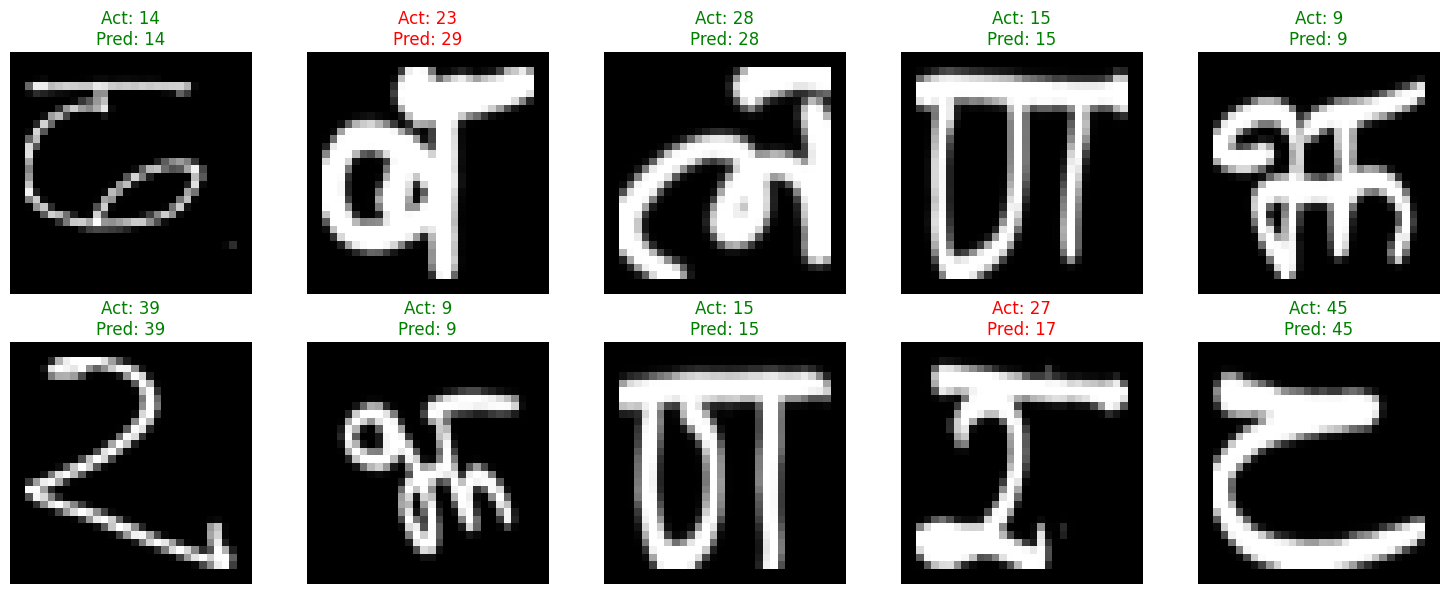

In [22]:
# 1. First, re-generate the predictions and store them in val_preds
with torch.no_grad():
    logits_val = X_val_rbf @ final_w
    val_preds = torch.argmax(logits_val, dim=1)

# 2. Define the visualization function
import matplotlib.pyplot as plt

def visualize_results(X_raw, Y_true, Y_pred, num_samples=10):
    # Select random indices from the validation set
    indices = np.random.choice(len(X_raw), num_samples, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        
        # X_val contains the original 32x32 arrays
        img = X_raw[idx]
        
        # Labels are 0-indexed in code, so add 1 for the original 1-46 range
        actual_label = Y_true[idx].item() + 1
        predicted_label = Y_pred[idx].item() + 1
        
        # Green for correct, Red for wrong
        color = 'green' if actual_label == predicted_label else 'red'
        
        plt.imshow(img, cmap='gray')
        plt.title(f"Act: {actual_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_results(X_val, Y_val_t, val_preds, num_samples=10)